## Advanced Box Score Calculations
Author: Akshay Easwaran <akeaswaran@me.com>

---
Based on work by ESPN's Bill Connelly, Football Outsiders, and Football Study Hall

Data from CollegeFootballData.com

Useful Resources for Stat Definitions:
- Football Study Hall website: https://www.footballstudyhall.com/
- Football Study Hall book: https://www.amazon.com/Study-Hall-College-Football-Stories/dp/1484989961
- Football Outsiders: https://www.footballoutsiders.com/info/glossary
- Example Advanced Box Score: https://twitter.com/ESPN_BillC/status/1176572006969597954/photo/1

**How to use this Notebook**

1. Dump game, play by play, and drive data for an entire season from CollegeFootballData.com.
2. Change the file names in the next cell to match where your data files are located.
3. Change the away and home team names appropriately.
4. Hit Cell > Run All Cells.

In [10]:
import pandas as pd

base_drives = pd.read_json('data/drives/drive-data-national.json')
base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed','start_period','end_period'], axis = 1, inplace=True) 
base_drives = base_drives[
    ~base_drives.drive_result.isin(['Uncategorized'])
]

games = pd.read_json('data/games/game-data-national.json')

selected_team = 'National'

In [11]:
# Data Cleaning
# Fix the bad yard line markers for away teams
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline

print("Total Drives:", len(drives))
# drives

Total Drives: 9829


In [12]:
print(selected_team, "Drives:", len(drives))

print(selected_team, "Avg Starting Field Position:", sum(drives.start_yardline) / len(drives))
print(selected_team, "Mdn Starting Field Position:", drives.start_yardline.median())
print("")

drives['yards_per_play'] = drives.apply(lambda x: (x.yards / x.plays) if (x.plays > 0) else 0, axis=1)
print(selected_team, "Avg Yards per Play:", drives.yards_per_play.mean())
print(selected_team, "Mdn Yards per Play:", drives.yards_per_play.median())

print("")
print(selected_team, "Avg Plays per Drive:", drives.plays.mean())
print(selected_team, "Mdn Plays per Drive:", drives.plays.median())

print("")
print(selected_team, "Avg Yards per Drive:", drives.yards.mean())
print(selected_team, "Mdn Yards per Drive:", drives.yards.median())

National Drives: 9829
National Avg Starting Field Position: 30.143758266354666
National Mdn Starting Field Position: 25.0

National Avg Yards per Play: 5.644933152502619
National Mdn Yards per Play: 4.076923076923077

National Avg Plays per Drive: 5.5379997965205
National Mdn Plays per Drive: 5.0

National Avg Yards per Drive: 31.092684911995118
National Mdn Yards per Drive: 23.0


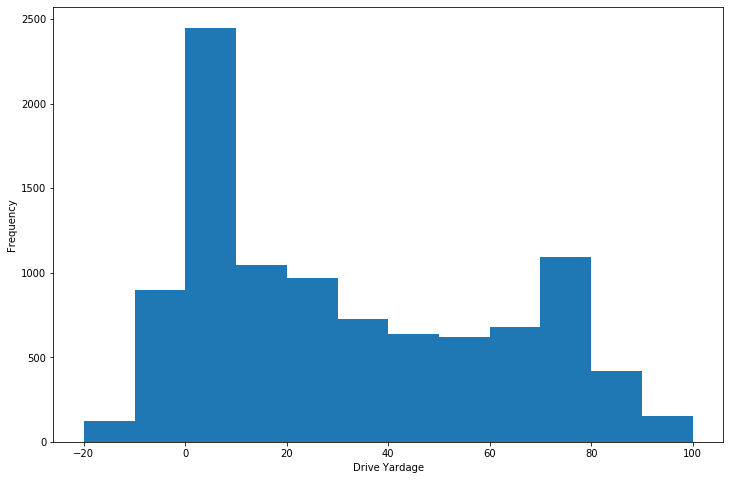

In [13]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=(12,8))
ax.hist(drives.yards, bins=[-20,-10,0,10,20,30,40,50,60,70,80,90,100]);
ax.set_ylabel("Frequency");
ax.set_xlabel("Drive Yardage");

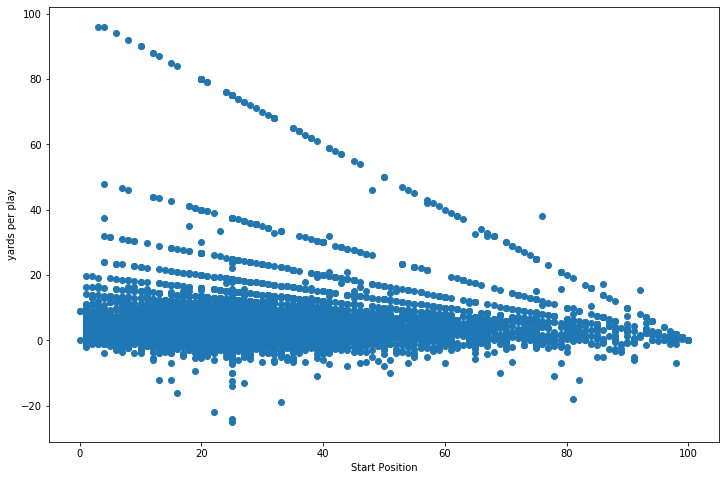

In [14]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
ax.scatter(drives.start_yardline, drives.yards_per_play);
ax.set_ylabel("yards per play");
ax.set_xlabel("Start Position");

In [15]:
pbp_data = pd.read_json('data/pbp/pbp-data-national.json')
# Eliminate garbage time plays
# garbage_time_data = pbp_data[
#     (pbp_data.down == 0)
#     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 38) & (pbp_data.period == 2))
#     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 28) & (pbp_data.period == 3))
#     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 22) & (pbp_data.period == 4))
# ]

print("Total Plays:", len(pbp_data))
# print("Garbage Time Plays:", len(garbage_time_data))
# pbp_data.drop(garbage_time_data.index, inplace=True)
print("Non-Garbage Time Plays:", len(pbp_data))

# Drop some unnecessary columns
pbp_data.drop(['offense_conference','defense_conference','clock'], axis = 1, inplace=True) 
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types))]
print("Total clean plays:", len(pbp_data))

Total Plays: 71085
Non-Garbage Time Plays: 71085
Total clean plays: 55336


In [16]:
import numpy as np

pbp_data.distance = pbp_data.distance.astype(float)

bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

def is_successful(down, distance, yards_gained, play_type):
    if (play_type in bad_types):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif (((down == 3) | (down == 4)) & (yards_gained >= distance)):
        return True
    else:
        return False
    
pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
pbp_data.play_successful.value_counts()

def is_explosive(yards_gained):
    if (yards_gained >= 15):
        return True
    else:
        return False
    
pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)

In [17]:
pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

print("Offensive Success Rates")
base_overall = len(pbp_data[(pbp_data.play_successful == True)]) / len(pbp_data)
print("Overall:",base_overall)
base_passing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
print("Passing:",base_passing)
base_rushing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
print("Rushing:",base_rushing)
print("")


print("Offensive Explosiveness Rates")
base_exp_overall = len(pbp_data[(pbp_data.play_explosive == True)]) / len(pbp_data)
print("Overall:",base_exp_overall)
base_exp_passing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
print("Passing:",base_exp_passing)
base_exp_rushing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
print("Rushing:",base_exp_rushing)
print("")

Offensive Success Rates
Overall: 0.40812490964290876
Passing: 0.43697036045898713
Rushing: 0.401593652747854

Offensive Explosiveness Rates
Overall: 0.11863886077779384
Passing: 0.1787292705672465
Rushing: 0.07315071303990972



In [20]:
# SR+
selected_team = 'Georgia Tech'
selected_team_data = pbp_data[
    (pbp_data.offense == selected_team)
    | (pbp_data.defense == selected_team)
]

overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

exp_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
exp_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
exp_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

def_overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
def_passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
def_rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])

exp_def_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
exp_def_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
exp_def_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])


def plus_adj(base, comp):
    diff = comp - base
    pct = (diff / base) * 100
    return 100 + pct

print(selected_team,"SR+ Stats")
print("")

print("Offensive (higher + is better)")
print("Overall Off SR:",overall)
print("Overall Off SR+:",plus_adj(base_overall, overall))
print("")
print("Passing Off SR:",passing)
print("Passing Off SR+:",plus_adj(base_passing, passing))
print("")
print("Rushing Off SR:",rushing)
print("Rushing Off SR+:",plus_adj(base_rushing, rushing))

print("")

print("Overall Off ER:",exp_overall)
print("Overall Off ER+:",plus_adj(base_exp_overall, exp_overall))
print("")
print("Passing Off ER:",exp_passing)
print("Passing Off ER+:",plus_adj(base_exp_passing, exp_passing))
print("")
print("Rushing Off ER:",exp_rushing)
print("Rushing Off ER+:",plus_adj(base_exp_rushing, exp_rushing))

print("")

print("Defensive (lower + is better)")
print("Overall Def SR:",def_overall)
print("Overall Def SR+:",plus_adj(base_overall, def_overall))
print("")
print("Passing Def SR:",def_passing)
print("Passing Def SR+:",plus_adj(base_passing, def_passing))
print("")
print("Rushing Def SR:",def_rushing)
print("Rushing Def SR+:",plus_adj(base_rushing, def_rushing))

print("")

print("Overall Def ER:",exp_def_overall)
print("Overall Def ER+:",plus_adj(base_exp_overall, exp_def_overall))
print("")
print("Passing Def ER:",exp_def_passing)
print("Passing Def ER+:",plus_adj(base_exp_passing, exp_def_passing))
print("")
print("Rushing Def ER:",exp_def_rushing)
print("Rushing Def ER+:",plus_adj(base_exp_rushing, exp_def_rushing))

Georgia Tech SR+ Stats

Offensive (higher + is better)
Overall Off SR: 0.3811074918566775
Overall Off SR+: 93.38011056226138

Passing Off SR: 0.36363636363636365
Passing Off SR+: 83.21762676406826

Rushing Off SR: 0.4
Rushing Off SR+: 99.60316784467344

Overall Off ER: 0.11074918566775244
Overall Off ER+: 93.34983911821399

Passing Off ER: 0.15454545454545454
Passing Off ER+: 86.46902326348787

Rushing Off ER: 0.08947368421052632
Rushing Off ER+: 122.31416549789621

Defensive (lower + is better)
Overall Def SR: 0.4036458333333333
Overall Def SR+: 98.90252317274766

Passing Def SR: 0.4015151515151515
Passing Def SR+: 91.88612955199204

Rushing Def SR: 0.4279661016949153
Rushing Def SR+: 106.56694864737305

Overall Def ER: 0.1015625
Overall Def ER+: 85.60643564356435

Passing Def ER: 0.18181818181818182
Passing Def ER+: 101.72826266292691

Rushing Def ER: 0.0635593220338983
Rushing Def ER+: 86.88817838210473
